In [7]:
import pandas as pd
import numpy as np
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', True)

In [9]:
path_1 = "xml_examples.csv"
path_2 = "zero_shot_learning_new.csv"
path_3 = "one_shot_learning_new.csv"
path_4 = "two_shot_learning_new.csv"
xml_examples = pd.read_csv(path_1)
zero_shot = pd.read_csv(path_2)
one_shot = pd.read_csv(path_3)
two_shot = pd.read_csv(path_4)


In [10]:
xml_df = xml_examples.pivot_table(index='Prompt', columns='Model Name', values='Behavior Tree', aggfunc='first')
zero_df = zero_shot.pivot_table(index='Prompt', columns='Model Name', values='Behavior Tree', aggfunc='first')
one_df = one_shot.pivot_table(index='Prompt', columns='Model Name', values='Behavior Tree', aggfunc='first')
two_df = two_shot.pivot_table(index='Prompt', columns='Model Name', values='Behavior Tree', aggfunc='first')


In [11]:
def rouge_scores(df):
    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    # Function to calculate ROUGE-L
    def calculate_rouge(row, model_name):
        if pd.isna(row[model_name]) or pd.isna(row['golden_label']):
            return None  # Skip calculation if either the model or golden label data is missing
        scores = scorer.score(row['golden_label'], row[model_name])
        return scores['rougeL'].fmeasure  # Returning the F-measure of ROUGE-L

    # List of model columns to compare with 'golden_label'
    model_columns = [col for col in df.columns if col != 'golden_label']  # Exclude the 'golden_label' from comparison list
    
    # Calculate ROUGE-L for each model comparison with 'golden_label'
    for model in model_columns:
        df[f'ROUGE-L_{model}'] = df.apply(calculate_rouge, axis=1, args=(model,))

# Apply the function to each dataframe
rouge_scores(xml_df)
rouge_scores(zero_df)
rouge_scores(one_df)
rouge_scores(two_df)


In [12]:
# Extracting columns of interest after renaming
def extract_and_rename_rouge_columns(df):
    rouge_columns = [col for col in df.columns if col.startswith('ROUGE-L_')]
    df_subset = df[rouge_columns].reset_index(drop=True)
    df_subset.rename(columns=lambda x: x.replace('ROUGE-L_', ''), inplace=True)
    return df_subset

ROUGE_L_two_shot = extract_and_rename_rouge_columns(two_df)
ROUGE_L_one_shot = extract_and_rename_rouge_columns(one_df)
ROUGE_L_zero_shot = extract_and_rename_rouge_columns(zero_df)
ROUGE_L_xml_structured = extract_and_rename_rouge_columns(xml_df)

In [13]:

# # Extracting columns of interest after renaming
# columns_of_interest = [
#     'ROUGE-L_Mistral-7b-Instruct-v3'
#     'ROUGE-L_llama-2-13b',
#     'ROUGE-L_llama-2-13b-chat',
#     'ROUGE-L_llama-2-7b-32k-instruct',
#     'ROUGE-L_llama-2-7b-chat',
#     'ROUGE-L_llama-3-8b-instruct',
#     'ROUGE-L_mistral-7b-instruct-v0',
#     'ROUGE-L_orca-2-7b',
#     'ROUGE-L_phi-2',
#     'ROUGE-L_westlake-7b-v2'
# ]

# # Reset the index if needed and select only the columns of interest
# ROUGE_L_two_shot = two_df[columns_of_interest].reset_index(drop=True)
# ROUGE_L_two_shot.rename(columns=lambda x: x.replace('ROUGE-L_', ''), inplace=True)
# ROUGE_L_one_shot = one_df[columns_of_interest].reset_index(drop=True)
# ROUGE_L_one_shot.rename(columns=lambda x: x.replace('ROUGE-L_', ''), inplace=True)
# ROUGE_L_zero_shot = zero_df[columns_of_interest].reset_index(drop=True)
# ROUGE_L_zero_shot.rename(columns=lambda x: x.replace('ROUGE-L_', ''), inplace=True)
# ROUGE_L_xml_structured = xml_df[columns_of_interest].reset_index(drop=True)
# ROUGE_L_xml_structured.rename(columns=lambda x: x.replace('ROUGE-L_', ''), inplace=True)


C:\Users\moham\AppData\Local\Temp\ipykernel_17832\4083084906.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


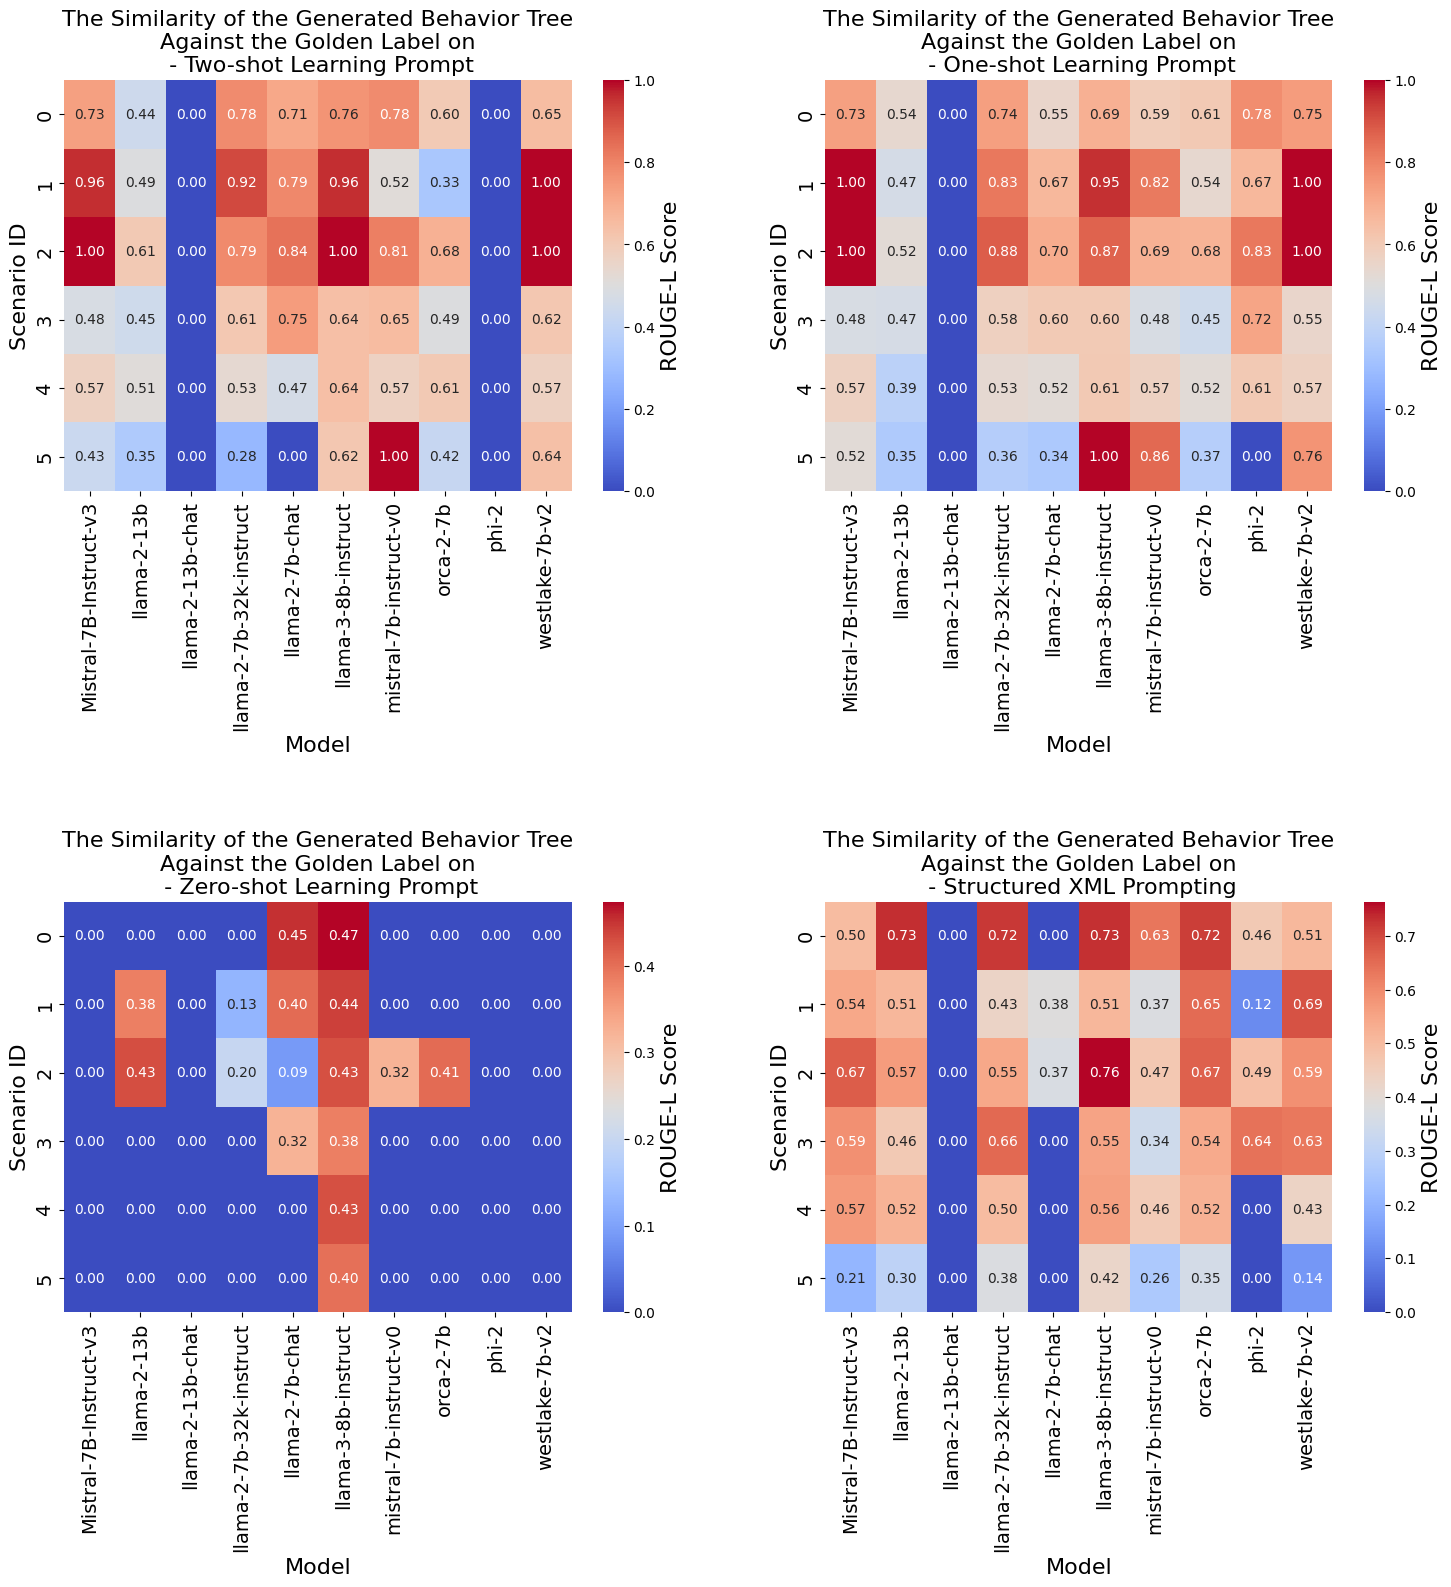

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot heatmaps in a 2x2 layout
def plot_heatmaps(data, titles):
    fig, axes = plt.subplots(2, 2, figsize=(18, 16), gridspec_kw={'hspace': 1})  # Adjust the subplot grid and space
    axes = axes.flatten()  # Flatten the 2x2 array to make indexing easier

    for ax, (df, title) in zip(axes, zip(data, titles)):
        # Using annot_kws to adjust font size of annotations
        sns.heatmap(df, annot=True, cmap='coolwarm', cbar=True,
                    cbar_kws={'label': 'ROUGE-L Score'},  # Customize the colorbar label size
                    fmt='.2f', ax=ax, annot_kws={"size": 10})  # Adjust the format here for two decimal places
        
        ax.figure.axes[-1].yaxis.label.set_size(16)
        ax.set_title(f"The Similarity of the Generated Behavior Tree\nAgainst the Golden Label on\n - {title}", fontsize=16)
        ax.set_xlabel('Model', fontsize=16)
        ax.set_ylabel('Scenario ID', fontsize=16)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.savefig("Heatmat of Scenarios with Models.png")
    plt.show()

# List of dataframes and their corresponding titles
dfs = [ROUGE_L_two_shot, ROUGE_L_one_shot, ROUGE_L_zero_shot, ROUGE_L_xml_structured]
titles = [
    'Two-shot Learning Prompt',
    'One-shot Learning Prompt',
    'Zero-shot Learning Prompt',
    'Structured XML Prompting'
]

# Call the function to plot the heatmaps
plot_heatmaps(dfs, titles)


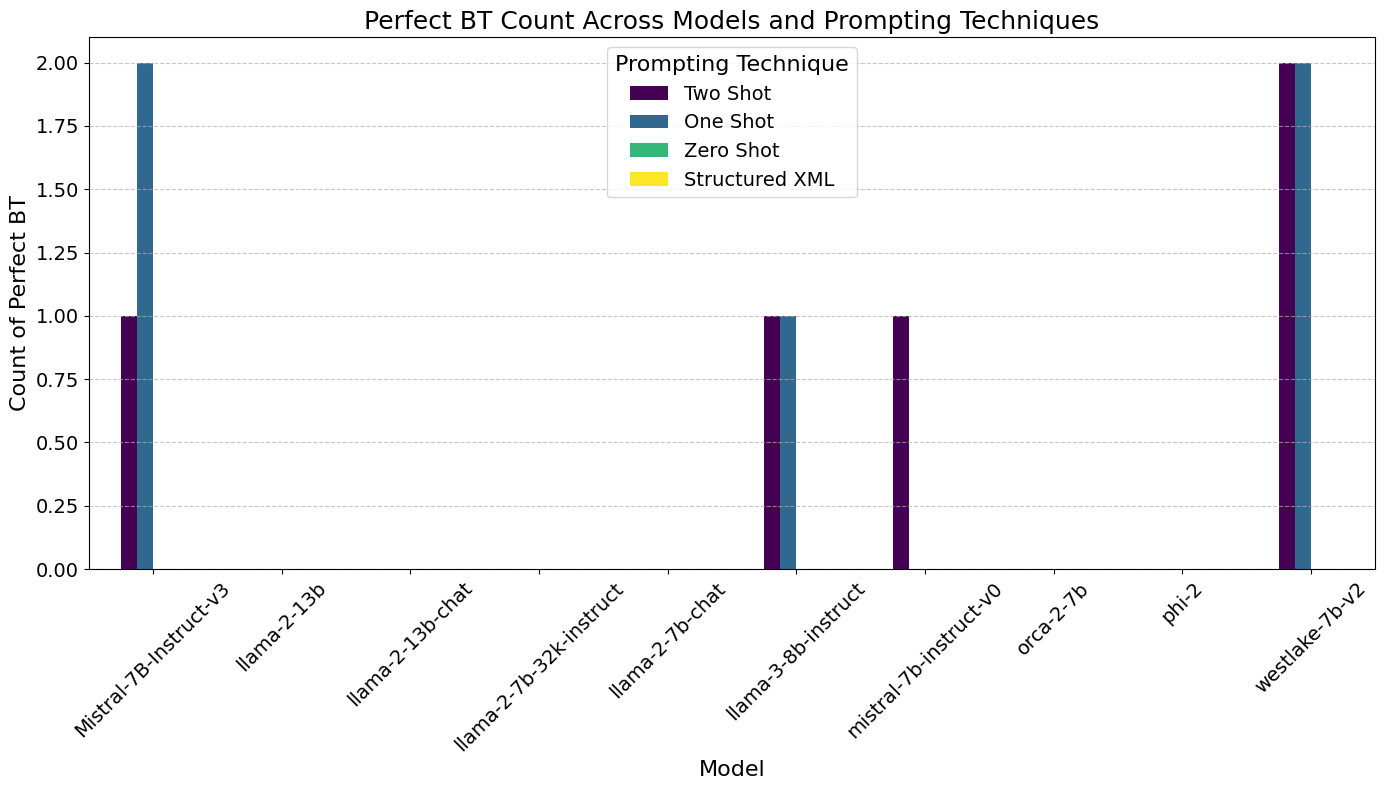

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate success counts (ROUGE-L score == 1)
def calculate_success_counts(df):
    return (df == 1).sum()

# Applying the function to each dataset
success_counts = {
    'Two Shot': calculate_success_counts(ROUGE_L_two_shot),
    'One Shot': calculate_success_counts(ROUGE_L_one_shot),
    'Zero Shot': calculate_success_counts(ROUGE_L_zero_shot),
    'Structured XML': calculate_success_counts(ROUGE_L_xml_structured)
}

# Convert dictionary to DataFrame for easier plotting
df_success_counts = pd.DataFrame(success_counts)

# Plotting the grouped bar chart
ax = df_success_counts.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Perfect BT Count Across Models and Prompting Techniques', fontsize=18)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Count of Perfect BT', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Prompting Technique', fontsize=14, title_fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Success_Counts_Across_Models_and_Prompts.png")
plt.show()


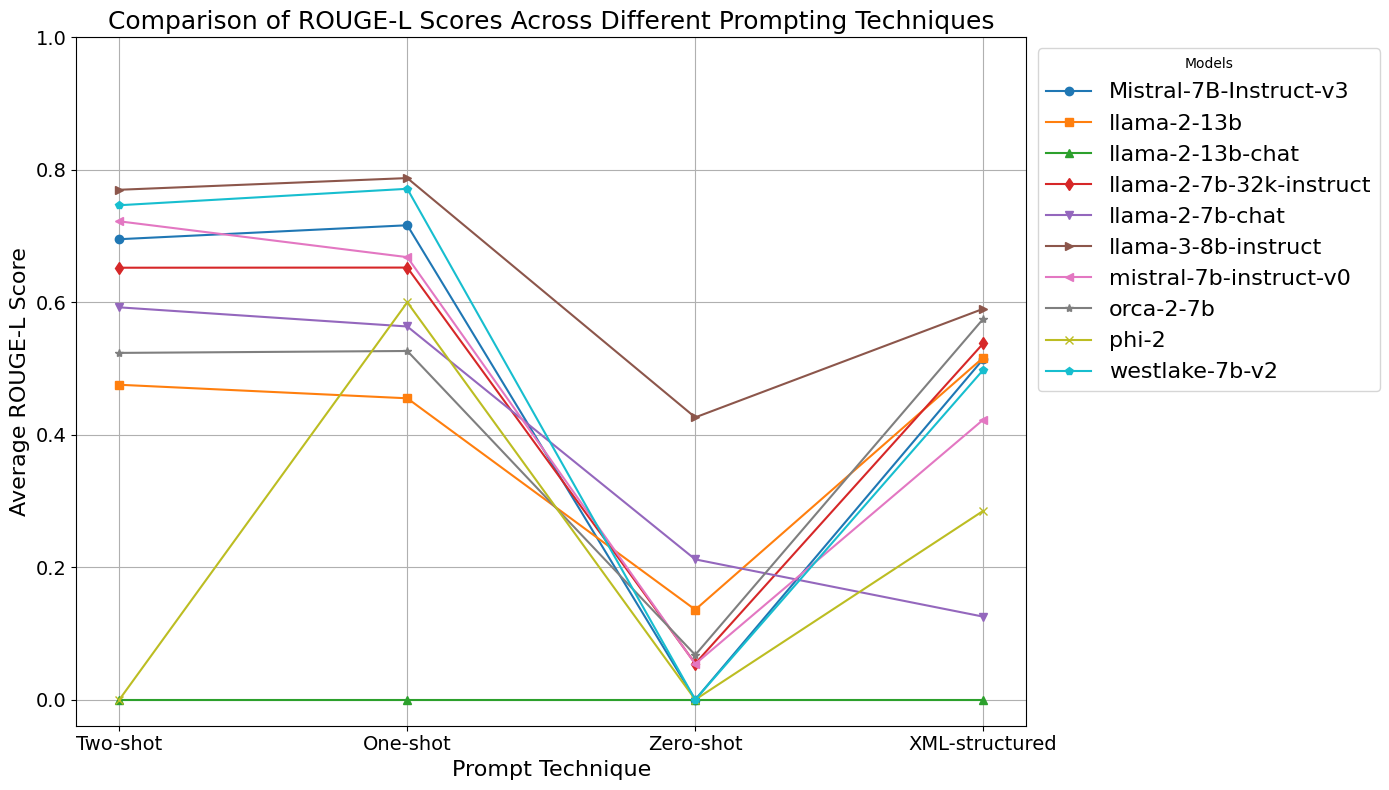

In [17]:

# Data preparation
prompt_techniques = ['Two-shot', 'One-shot', 'Zero-shot', 'XML-structured']
models = ROUGE_L_two_shot.columns  # Assuming all DataFrames have the same structure and column names

# Define markers for each model
markers = ['o', 's', '^', 'd', 'v', '>', '<', '*', 'x', 'p']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Iterate through each model and plot its data with a different marker
for model, marker in zip(models, markers):
    scores = [
        ROUGE_L_two_shot[model].mean(),
        ROUGE_L_one_shot[model].mean(),
        ROUGE_L_zero_shot[model].mean(),
        ROUGE_L_xml_structured[model].mean()
    ]
    ax.plot(prompt_techniques, scores, marker=marker, label=model)

# Set the title and axis labels
ax.set_title('Comparison of ROUGE-L Scores Across Different Prompting Techniques',fontsize=18)
ax.set_xlabel('Prompt Technique',fontsize=16)
ax.set_ylabel('Average ROUGE-L Score',fontsize=16)

# Add a legend outside the plot area
ax.legend(title="Models", bbox_to_anchor=(1, 1), loc='upper left',fontsize=16)

# Show grid for better readability
plt.grid(True)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylim(None, 1) 
# Show the plot
plt.tight_layout()  # Adjust layout to make room for the legend
plt.savefig("Comparison of ROUGE-L Scores Across Different Prompting Techniques.png")
plt.show()


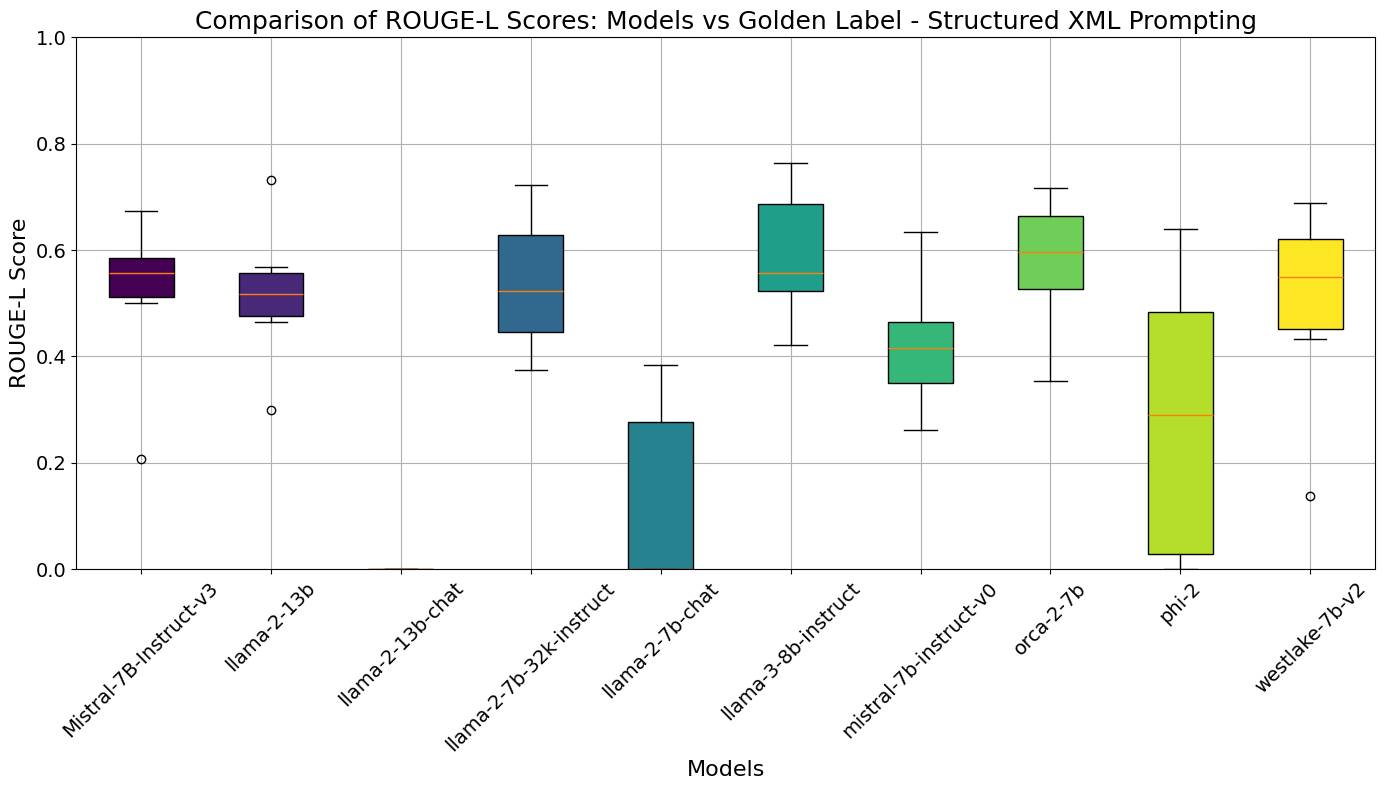

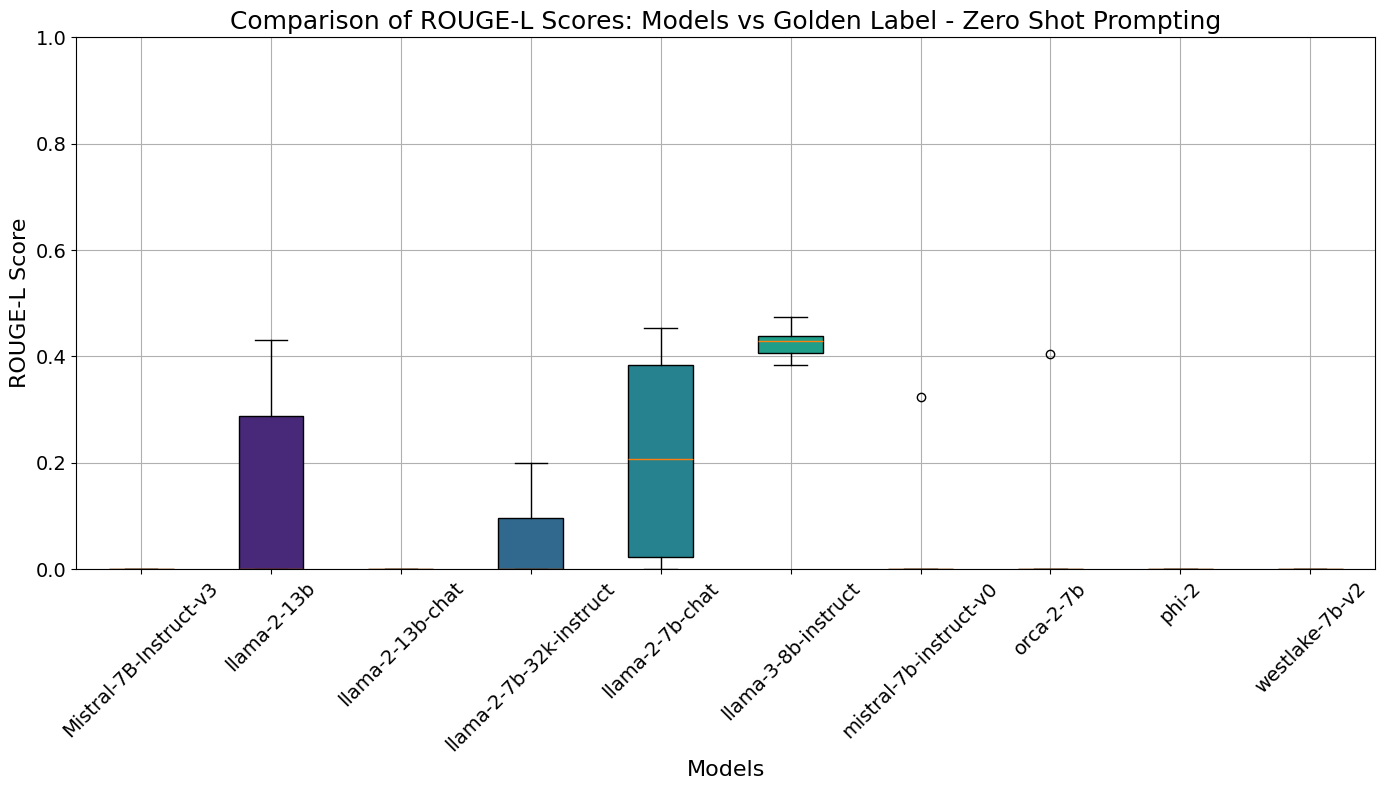

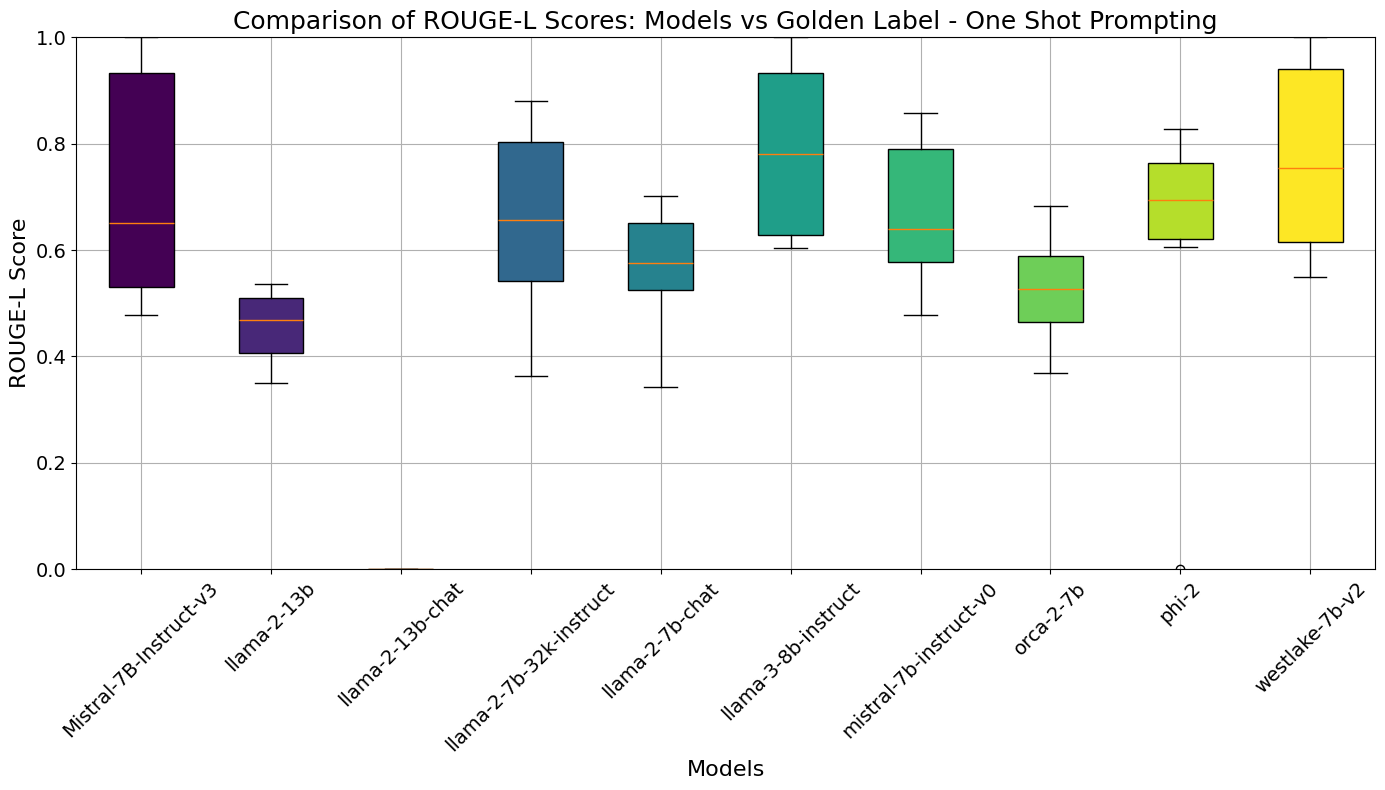

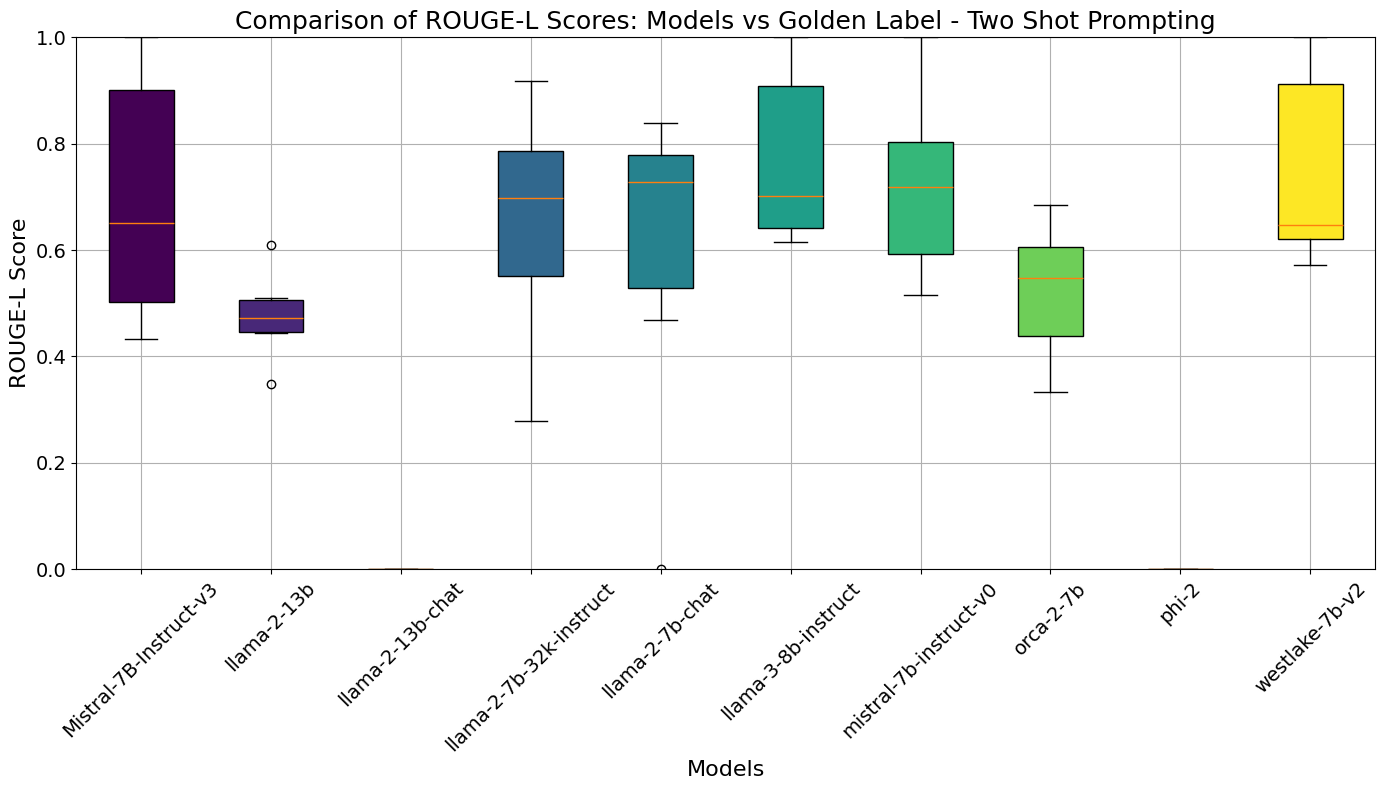

In [18]:


def plot_rouge_scores(df, title):
    # Get column names, excluding any non-score columns if present
    model_columns = df.columns.tolist()  
    
    # Prepare the data for plotting
    data_to_plot = [df[col].dropna() for col in model_columns]  # Collect only non-NaN values
    
    # Plotting
    plt.figure(figsize=(14, 8))
    boxplot = plt.boxplot(data_to_plot, labels=model_columns, patch_artist=True)
    
    # Setting the colors using a color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(model_columns)))  # Gradient color map
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
    
    # Formatting the plot
    plt.title(title, fontsize=18)
    plt.xlabel('Models', fontsize=16)
    plt.ylabel('ROUGE-L Score', fontsize=16)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1)  # Ensure ROUGE scores are between 0 and 1
    plt.grid(True)  # Adding a grid for better readability
    plt.tight_layout()
    plt.savefig(title + ".png")
    plt.show()

# Now, call the function for each of your DataFrames
plot_rouge_scores(ROUGE_L_xml_structured, 'Comparison of ROUGE-L Scores: Models vs Golden Label - Structured XML Prompting')
plot_rouge_scores(ROUGE_L_zero_shot, 'Comparison of ROUGE-L Scores: Models vs Golden Label - Zero Shot Prompting')
plot_rouge_scores(ROUGE_L_one_shot, 'Comparison of ROUGE-L Scores: Models vs Golden Label - One Shot Prompting')
plot_rouge_scores(ROUGE_L_two_shot, 'Comparison of ROUGE-L Scores: Models vs Golden Label - Two Shot Prompting')


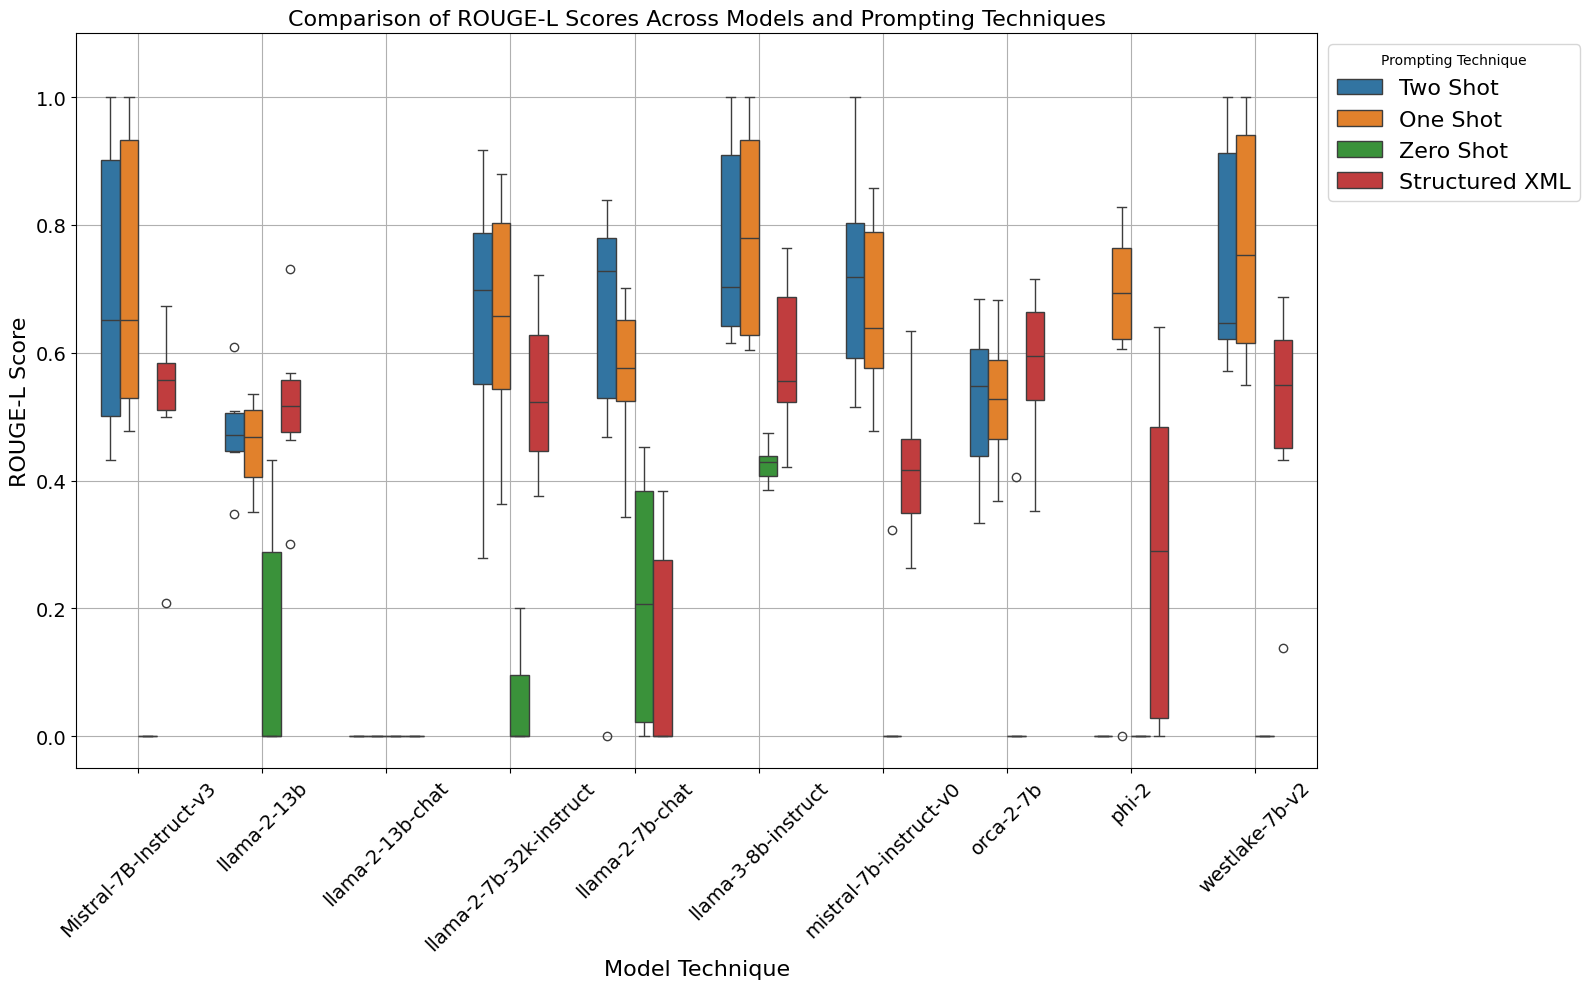

In [22]:

# Convert the columns to a flat format suitable for Seaborn's boxplot
def prepare_data(df, label):
    # Stack the data and reset index to move all headers to columns
    df_stacked = df.stack().reset_index()
    df_stacked.columns = ['Model', 'Technique', 'ROUGE-L Score']
    df_stacked['Prompting Technique'] = label
    return df_stacked

# Prepare each dataset
data_two_shot = prepare_data(ROUGE_L_two_shot, 'Two Shot')
data_one_shot = prepare_data(ROUGE_L_one_shot, 'One Shot')
data_zero_shot = prepare_data(ROUGE_L_zero_shot, 'Zero Shot')
data_xml_structured = prepare_data(ROUGE_L_xml_structured, 'Structured XML')

# Combine all data into a single DataFrame
combined_data = pd.concat([data_two_shot, data_one_shot, data_zero_shot, data_xml_structured], ignore_index=True)

# Plotting
plt.figure(figsize=(16, 10))
boxplot = sns.boxplot(x='Technique', y='ROUGE-L Score', hue='Prompting Technique', data=combined_data, width=0.6)  # Adjust box width
plt.title('Comparison of ROUGE-L Scores Across Models and Prompting Techniques',fontsize=16)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Model Technique',fontsize=16)
plt.ylabel('ROUGE-L Score',fontsize=16)
plt.legend(title='Prompting Technique', bbox_to_anchor=(1, 1), loc='upper left',fontsize=16)
plt.grid(True)

# Adjust spacing between the models
boxplot.xaxis.set_major_locator(plt.MaxNLocator(len(combined_data['Technique'].unique()) + 1))  # Adjust the number of ticks to create more space
plt.ylim(None, 1.1)
plt.tight_layout()
plt.savefig("ROUGE-L Scores Across Models and Prompting Techniques boxplot.png")
plt.show()


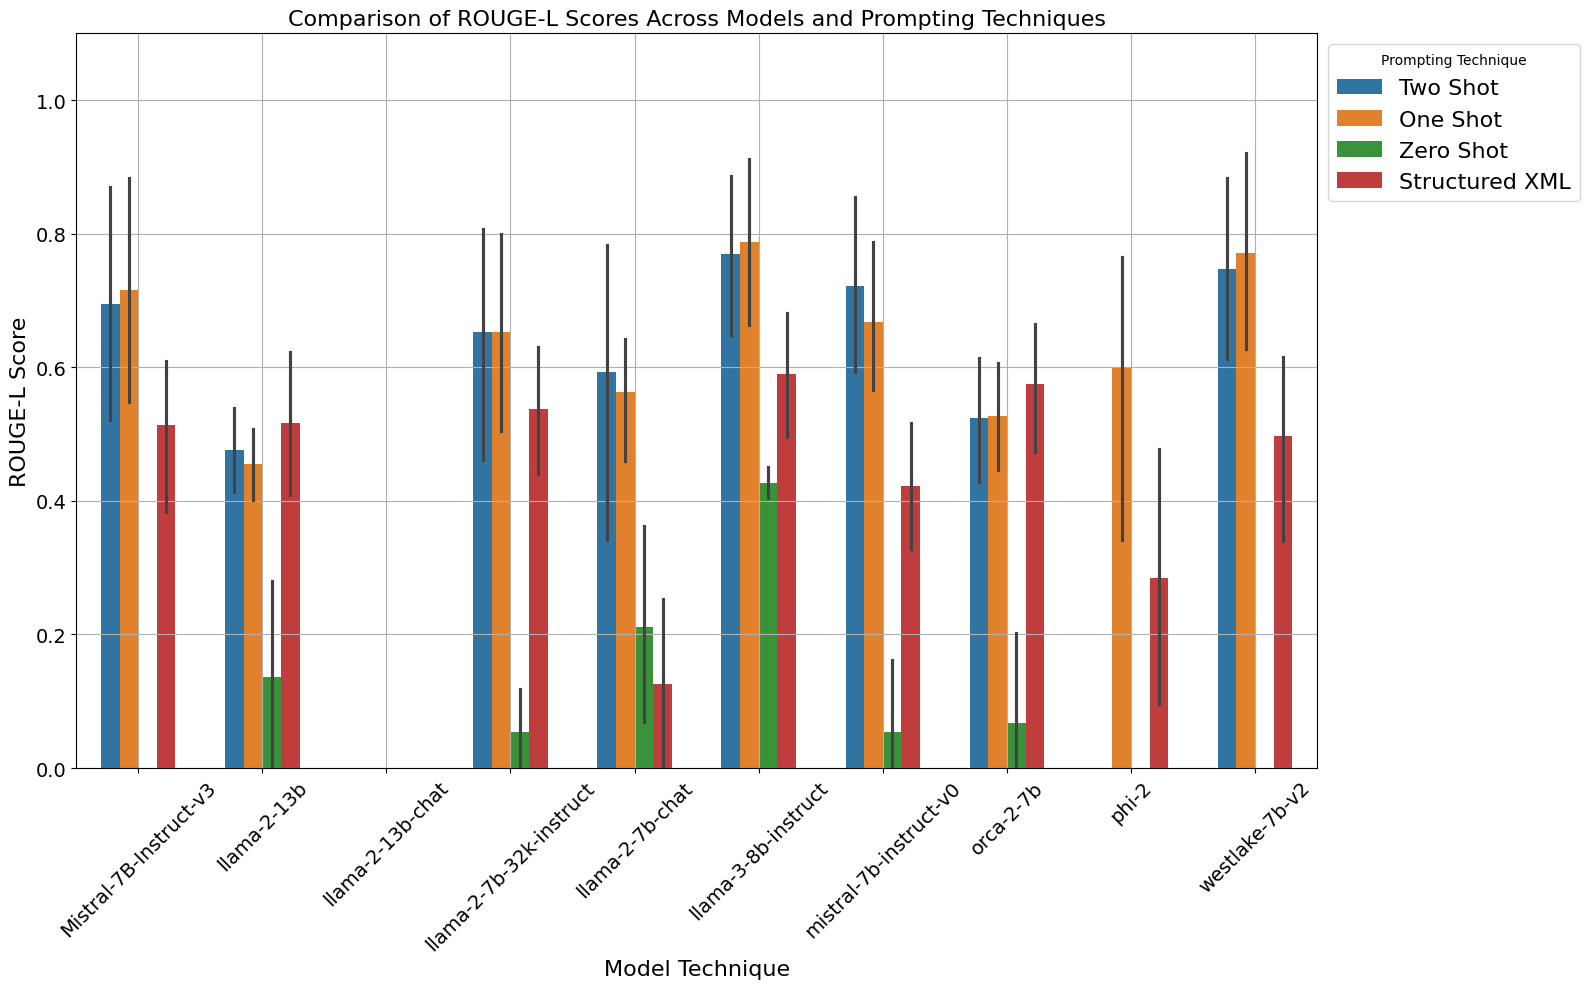

In [23]:


# Convert the columns to a flat format suitable for Seaborn's boxplot
def prepare_data(df, label):
    # Stack the data and reset index to move all headers to columns
    df_stacked = df.stack().reset_index()
    df_stacked.columns = ['Model', 'Technique', 'ROUGE-L Score']
    df_stacked['Prompting Technique'] = label
    return df_stacked

# Prepare each dataset
data_two_shot = prepare_data(ROUGE_L_two_shot, 'Two Shot')
data_one_shot = prepare_data(ROUGE_L_one_shot, 'One Shot')
data_zero_shot = prepare_data(ROUGE_L_zero_shot, 'Zero Shot')
data_xml_structured = prepare_data(ROUGE_L_xml_structured, 'Structured XML')

# Combine all data into a single DataFrame
combined_data = pd.concat([data_two_shot, data_one_shot, data_zero_shot, data_xml_structured], ignore_index=True)

# Plotting
plt.figure(figsize=(16, 10))
boxplot = sns.barplot(x='Technique', y='ROUGE-L Score', hue='Prompting Technique', data=combined_data, width=0.6)  # Adjust box width
plt.title('Comparison of ROUGE-L Scores Across Models and Prompting Techniques',fontsize=16)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Model Technique',fontsize=16)
plt.ylabel('ROUGE-L Score',fontsize=16)
plt.legend(title='Prompting Technique', bbox_to_anchor=(1, 1), loc='upper left',fontsize=16)
plt.grid(True)

# Adjust spacing between the models
boxplot.xaxis.set_major_locator(plt.MaxNLocator(len(combined_data['Technique'].unique()) + 1))  # Adjust the number of ticks to create more space
plt.ylim(None, 1.1)
plt.tight_layout()
plt.savefig("ROUGE-L Scores Across Models and Prompting Techniques barplot.png")
plt.show()


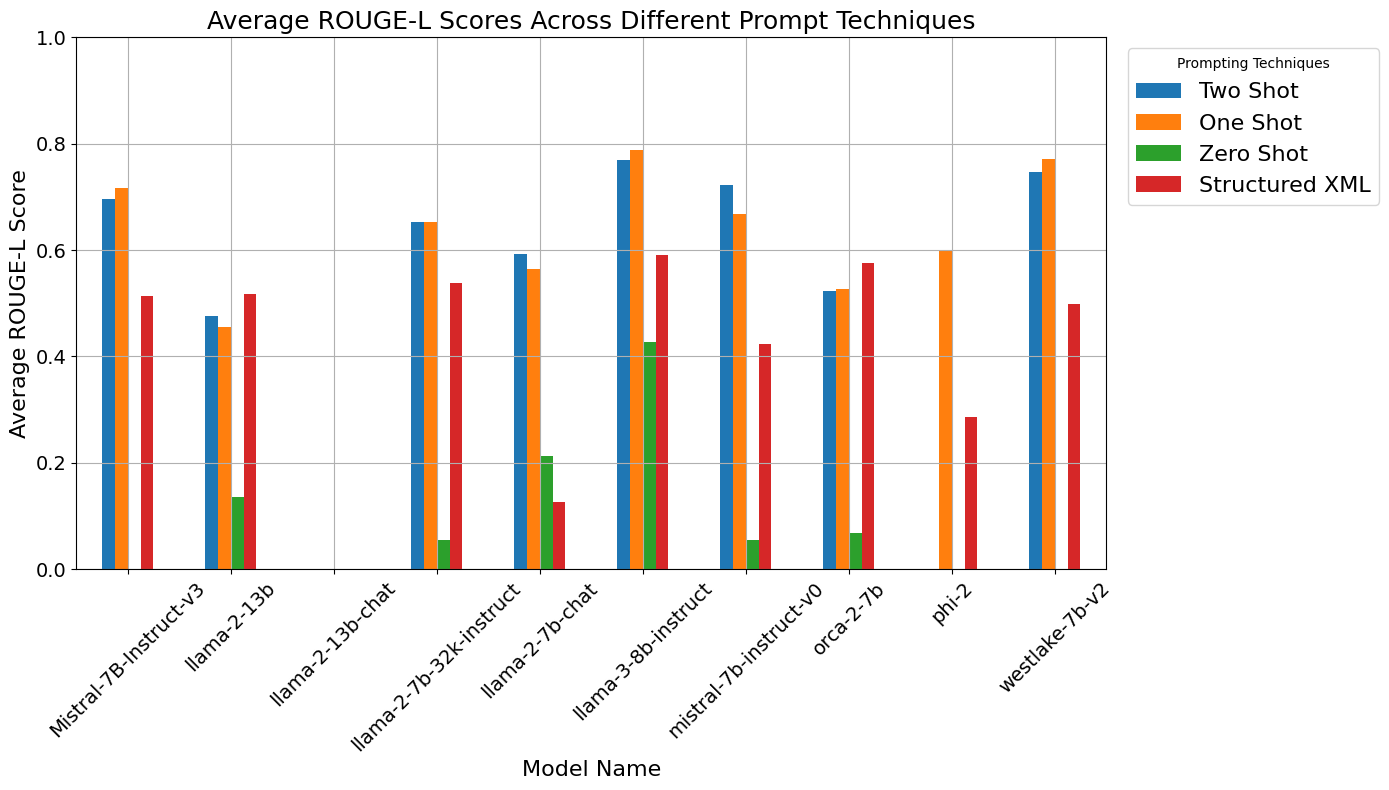

In [24]:

# Gather data
data = {
    'Two Shot': ROUGE_L_two_shot.mean(),
    'One Shot': ROUGE_L_one_shot.mean(),
    'Zero Shot': ROUGE_L_zero_shot.mean(),
    'Structured XML': ROUGE_L_xml_structured.mean()
}

# Convert data to DataFrame for easier plotting
df_plot = pd.DataFrame(data)

# Plotting

ax = df_plot.plot(kind='bar', figsize=(14, 8))
plt.grid(True)
plt.title('Average ROUGE-L Scores Across Different Prompt Techniques',fontsize=18)
plt.xlabel('Model Name',fontsize=16)
plt.ylabel('Average ROUGE-L Score',fontsize=16)
plt.xticks(rotation=45,fontsize=14)
plt.legend(title='Prompting Technique')

# Adding a legend with a title, adjusting its location
plt.legend(title="Prompting Techniques", bbox_to_anchor=(1.01, 1), loc='upper left',fontsize=16)
plt.yticks(fontsize=14)
# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()
plt.savefig("Average ROUGE-L Scores Across Different Prompt Techniques  .png")
plt.ylim(None, 1) 
plt.show()
